# Facial Emotion Recognition

In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf

In [4]:
print(tf.__version__)

2.18.0


In [5]:
!pip install keras==2.4.0


INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
ERROR: Cannot install keras, keras==2.4.0 and tensorflow==2.18.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested keras==2.4.0
    tensorflow 2.18.0 depends on keras>=3.5.0
    The user requested keras==2.4.0
    tensorflow 2.19.0 depends on keras>=3.5.0
    The user requested keras==2.4.0
    tensorflow 2.18.1 d

In [1]:
#list of useful imports that  I will use
%matplotlib inline
import os
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import random
from keras.preprocessing import image
import tensorflow as tf


from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [3]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# https://www.kaggle.com/code/prabhuyesu/american-sign-language-cnn/edit

file = '/content/drive/MyDrive/ml/archive (3).zip'

##Unziping data set

In [5]:
import zipfile as zf
data_zip = zf.ZipFile(file)
data_zip.extractall()
!ls

asl_dataset  drive  sample_data


In [6]:
data = 'asl_dataset'

In [7]:
Images = []
import os
for dirname, _, filenames in os.walk(data):
    for filename in filenames:
        img = os.path.join(dirname, filename)
        Images.append(img)

In [8]:
Images[:10]

['asl_dataset/o/hand5_o_dif_seg_1_cropped.jpeg',
 'asl_dataset/o/hand2_o_right_seg_4_cropped.jpeg',
 'asl_dataset/o/hand1_o_right_seg_3_cropped.jpeg',
 'asl_dataset/o/hand1_o_dif_seg_3_cropped.jpeg',
 'asl_dataset/o/hand3_o_dif_seg_5_cropped.jpeg',
 'asl_dataset/o/hand4_o_bot_seg_5_cropped.jpeg',
 'asl_dataset/o/hand1_o_left_seg_5_cropped.jpeg',
 'asl_dataset/o/hand1_o_left_seg_1_cropped.jpeg',
 'asl_dataset/o/hand2_o_dif_seg_5_cropped.jpeg',
 'asl_dataset/o/hand1_o_right_seg_1_cropped.jpeg']

In [9]:
len(Images)

5030

In [10]:
Class_label = []
for i in Images:
  j = i.split("/")
  #print(j[1])
  Class_label.append(j[1])


In [11]:
Class_label[:10]

['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']

In [12]:
len(Class_label)

5030

In [13]:
# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
temp = list(zip(Images, Class_label))
random.shuffle(temp)
Images, Class_label = zip(*temp)

In [14]:
data = pd.DataFrame(list(zip(Images, Class_label)), columns =['Image_path', 'Class_label'])

In [15]:
data.shape

(5030, 2)

In [16]:
data.head(5)

,Image_path,Class_label
0,asl_dataset/q/hand5_q_bot_seg_5_cropped.jpeg,q
1,asl_dataset/asl_dataset/1/hand5_1_bot_seg_2_cr...,asl_dataset
2,asl_dataset/asl_dataset/0/hand1_0_left_seg_3_c...,asl_dataset
3,asl_dataset/asl_dataset/e/hand3_e_dif_seg_2_cr...,asl_dataset
4,asl_dataset/asl_dataset/y/hand5_y_bot_seg_1_cr...,asl_dataset


In [17]:
data.Class_label.value_counts()

,count
Class_label,
asl_dataset,2515
q,70
i,70
5,70
r,70
p,70
m,70
s,70
x,70


In [18]:
data=data[data['Class_label'] != 'asl_dataset']

In [19]:
data.Class_label.value_counts()

,count
Class_label,
q,70
i,70
5,70
r,70
p,70
m,70
s,70
x,70
l,70


In [20]:
data.head(5)

,Image_path,Class_label
0,asl_dataset/q/hand5_q_bot_seg_5_cropped.jpeg,q
7,asl_dataset/i/hand1_i_top_seg_4_cropped.jpeg,i
8,asl_dataset/5/hand2_5_right_seg_3_cropped.jpeg,5
10,asl_dataset/r/hand1_r_dif_seg_2_cropped.jpeg,r
12,asl_dataset/p/hand1_p_top_seg_5_cropped.jpeg,p


In [21]:
# from sklearn.utils import resample
# # Separate majority and minority classes
# df_c0 = data[data['Class_label']== 'surprise']
# df_c1 = data[data['Class_label']== 'happy']
# df_c2 = data[data['Class_label']== 'disgust']
# df_c3 = data[data['Class_label']== 'anger']
# df_c4 = data[data['Class_label']== 'sadness']
# df_c5 = data[data['Class_label']== 'fear']
# df_c6 = data[data['Class_label']== 'contempt']


# # Downsample majority class
# df_c0_upsampled = resample(df_c0, replace=False,  n_samples = 200,random_state=123)
# df_c1_upsampled = resample(df_c1, replace=False,  n_samples = 200,random_state=123)
# df_c2_upsampled = resample(df_c2, replace=True,  n_samples = 200,random_state=123)
# df_c3_upsampled = resample(df_c3, replace=True,  n_samples = 200,random_state=123)
# df_c4_upsampled = resample(df_c4, replace=True,  n_samples = 200,random_state=123)
# df_c5_upsampled = resample(df_c5, replace=True,  n_samples = 200,random_state=123)
# df_c6_upsampled = resample(df_c6, replace=True,  n_samples = 200,random_state=123)

# # Combine minority class with downsampled majority class
# df_upsampled = pd.concat([df_c0_upsampled,df_c1_upsampled,df_c2_upsampled,df_c3_upsampled,df_c4_upsampled,df_c5_upsampled,df_c6_upsampled])

# # Display new class counts
# df_upsampled['Class_label'].value_counts()

<ipython-input-22-8761af1cdf70>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Class_label", data=data, palette=sns.color_palette("cubehelix", 4))
<ipython-input-22-8761af1cdf70>:4: UserWarning: 
The palette list has fewer values (4) than needed (36) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x="Class_label", data=data, palette=sns.color_palette("cubehelix", 4))


Text(0.5, 0, 'Class_label')

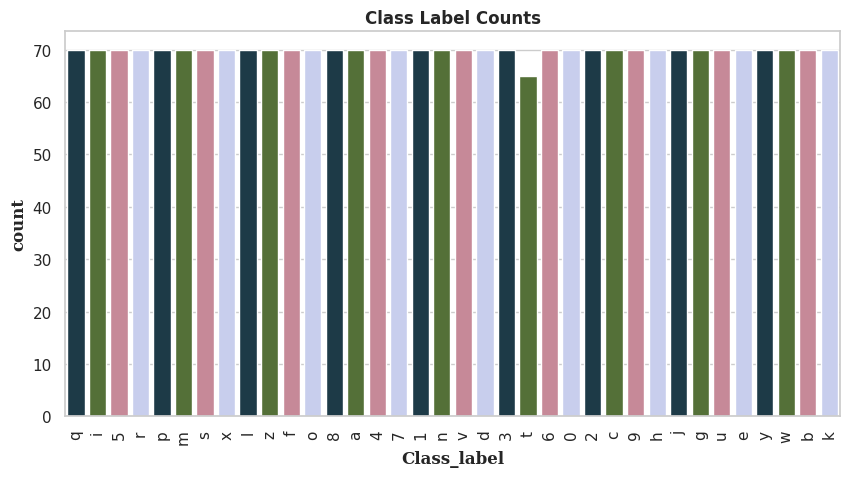

In [22]:
#counts of top 10 drugs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="Class_label", data=data, palette=sns.color_palette("cubehelix", 4))
plt.xticks(rotation=90)
plt.title("Class Label Counts", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("Class_label", {"fontname": "serif", "fontweight":"bold"})

In [23]:
data = data.sample(frac=1)

In [24]:
data.head()

,Image_path,Class_label
3478,asl_dataset/x/hand2_x_dif_seg_1_cropped.jpeg,x
386,asl_dataset/c/hand2_c_left_seg_4_cropped.jpeg,c
1446,asl_dataset/3/hand1_3_dif_seg_4_cropped.jpeg,3
2345,asl_dataset/w/hand1_w_bot_seg_3_cropped.jpeg,w
2366,asl_dataset/h/hand2_h_bot_seg_2_cropped.jpeg,h


## Resize the images

In [59]:
def resize_images(img):
  #file = Image.open(img)
  file = cv2.imread(img)
  #img = file.convert('RGB')
  #img_bgr= img.resize((48, 48))
  resized = cv2.resize(file, (48,48), interpolation = cv2.INTER_AREA)
  img_bgr = np.array(resized)
  return img_bgr

In [60]:
from PIL import Image

In [61]:
#save resized images into images.
images = [resize_images(img) for img in data['Image_path']]

In [62]:
# print number of classes in our dataset
num_classes = len(np.unique(data['Class_label']))

In [63]:
num_classes

36

In [64]:
# save the class into class_names
class_names = list(data['Class_label'])

In [65]:
# Print the shape of the image
images[10].shape

(48, 48, 3)

Text(0.5, 1.0, 'w')

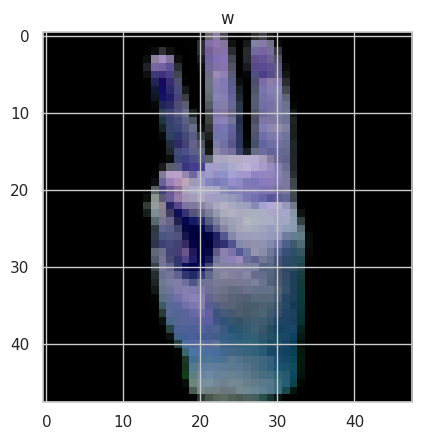

In [66]:
#See the image with class label
plt.imshow(images[5])
plt.title(class_names[5])

Text(0.5, 1.0, 's')

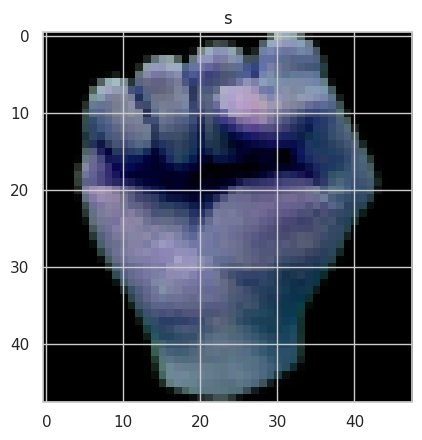

In [67]:
#See the image with class label
plt.imshow(images[10])
plt.title(class_names[10])

Text(0.5, 1.0, '4')

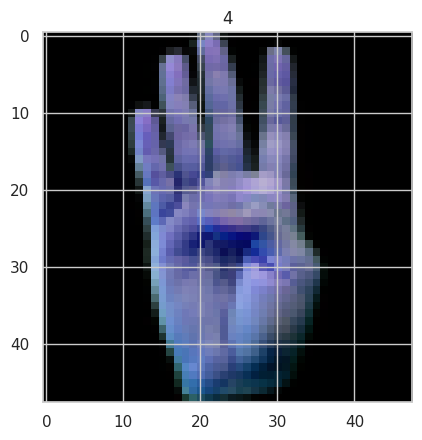

In [68]:
#See the image with class label
plt.imshow(images[400])
plt.title(class_names[400])

Text(0.5, 1.0, '9')

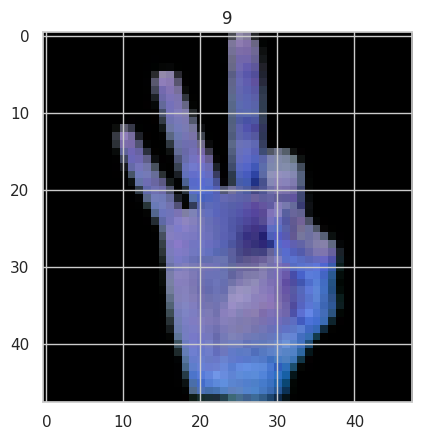

In [69]:
#See the image with class label
plt.imshow(images[70])
plt.title(class_names[70])




























## Label encoder

In [70]:

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(data['Class_label'])

In [71]:
data['Class_label'][:10]

,Class_label
3478,x
386,c
1446,3
2345,w
2366,h
2241,w
3843,8
3589,9
2739,w
2516,9


In [72]:
images = np.array(images)

In [73]:
images.shape

(2515, 48, 48, 3)

## Spliting data into training and testing

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3,stratify = y,random_state=42)

In [75]:
X_train.shape

(1760, 48, 48, 3)

In [76]:
X_test.shape

(755, 48, 48, 3)

# CNN Model

In [92]:
# Set the CNN model

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (48, 48, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(36, activation = "softmax"))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 347,204 (1.32 MB)

 Trainable params: 347,204 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Compile the model
opt = Adam(learning_rate=0.001)

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

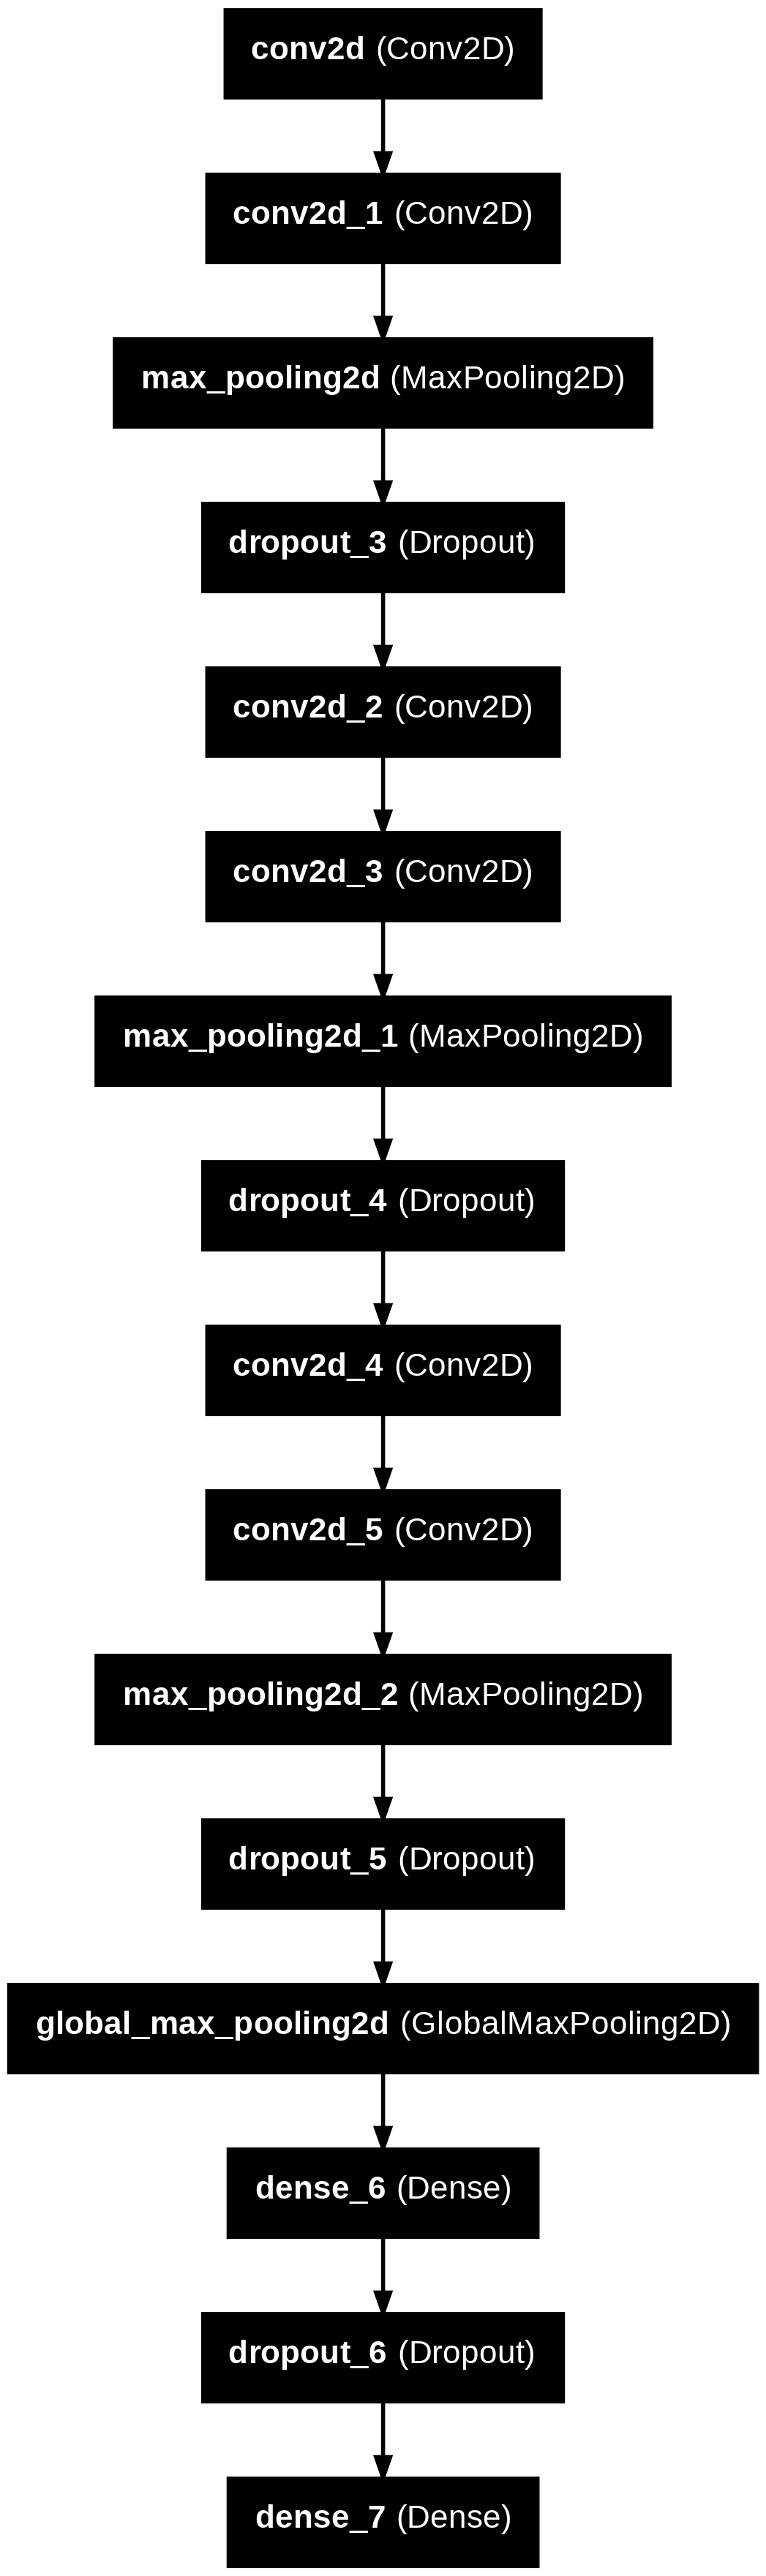

In [94]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

In [95]:
import warnings
warnings.filterwarnings("ignore")

In [96]:
# Fit the model
history = model.fit(X_train, y_train, epochs =10, validation_data = (X_test,y_test),batch_size = 128)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 912ms/step - accuracy: 0.0319 - loss: 16.0514 - val_accuracy: 0.0503 - val_loss: 3.5710
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0322 - loss: 3.5906 - val_accuracy: 0.0715 - val_loss: 3.5515
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0450 - loss: 3.5499 - val_accuracy: 0.0689 - val_loss: 3.4354
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0513 - loss: 3.4977 - val_accuracy: 0.2066 - val_loss: 3.3429
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0880 - loss: 3.3312 - val_accuracy: 0.2940 - val_loss: 3.1316
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1294 - loss: 3.0356 - val_accuracy: 0.2000 - val_loss: 2.8496
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2130 - loss: 2.7153 - val_accuracy: 0.2543 - val_loss: 2.3898
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2681 - loss: 2.4148 - val_accuracy: 0.4596 

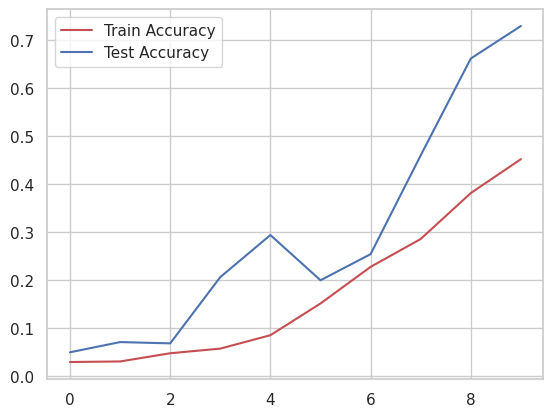

In [98]:
# plot the accuracy plot
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

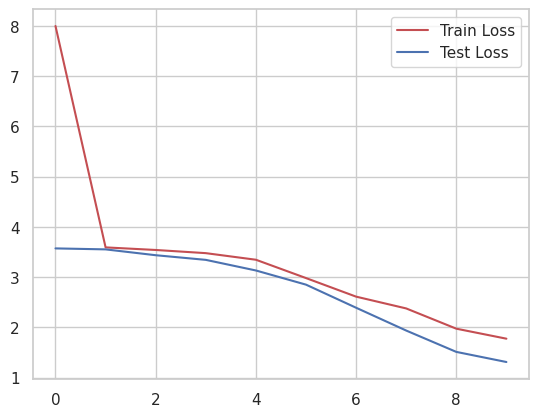

In [99]:
# plot the accuracy plot
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [100]:
file_name = '/content/drive/MyDrive/ml/sign_language_cnn.h5'

In [77]:
# Save the model
tf.keras.models.save_model(model,file_name)

In [101]:
# print the test accuracy
score_1 = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_1[1])

Test accuracy: 0.7284768223762512


In [104]:
results = pd.DataFrame(columns=["Model",'Test Accuracy'])

In [105]:
new = ['CNN ',score_1[1]]
results.loc[1] = new

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


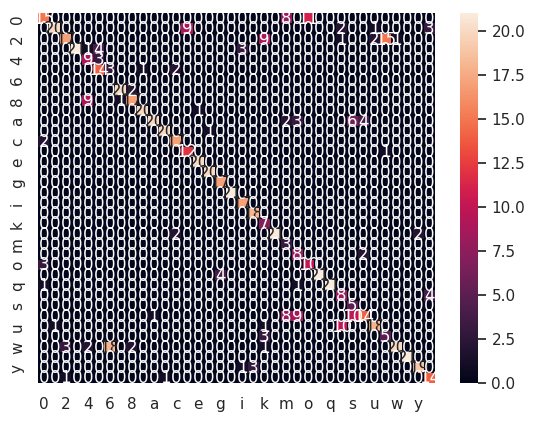

In [106]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names = enc.classes_
# Get predicted labels as discrete values instead of probabilities
y_pred = np.argmax(model.predict(X_test), axis=1)
df_heatmap = pd.DataFrame(confusion_matrix(y_pred,np.argmax(y_test,axis=1)),columns=class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


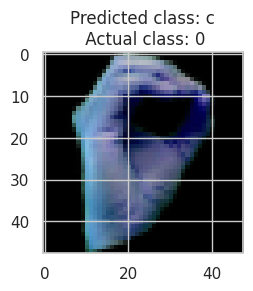

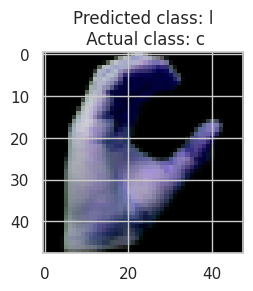

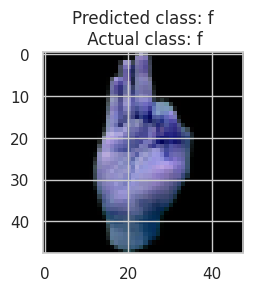

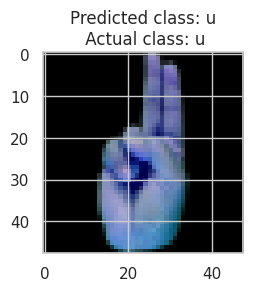

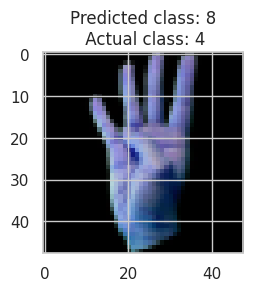

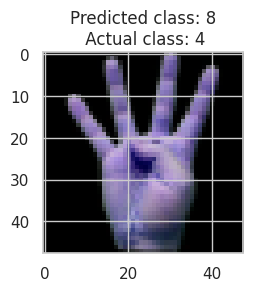

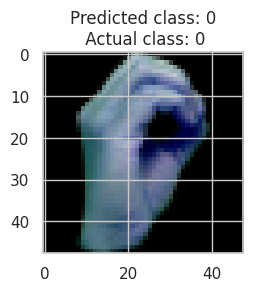

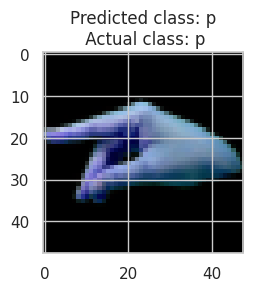

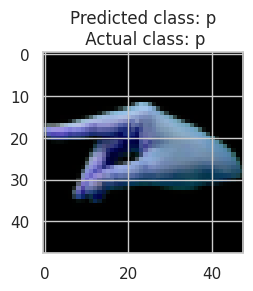

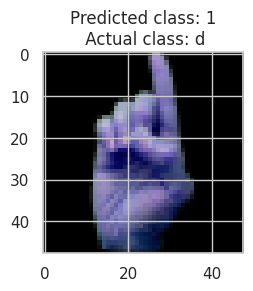

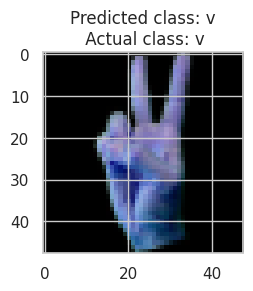

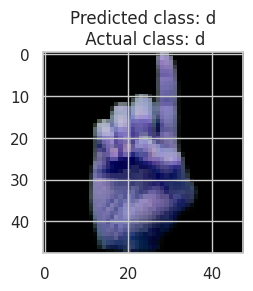

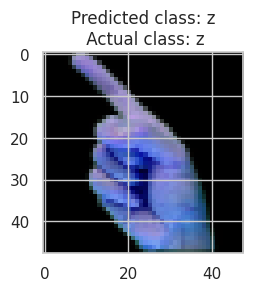

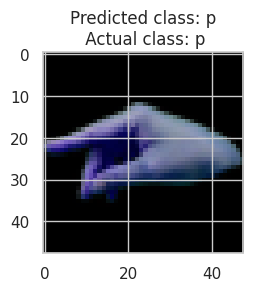

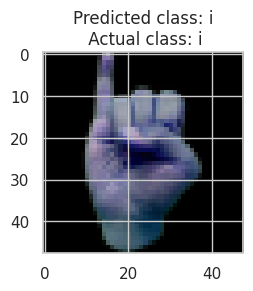

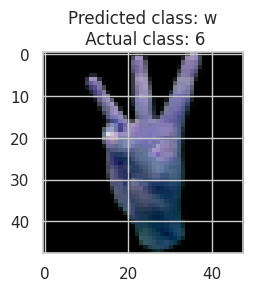

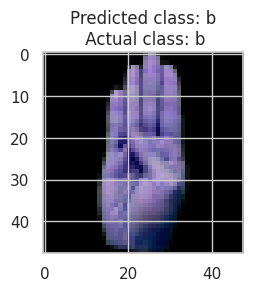

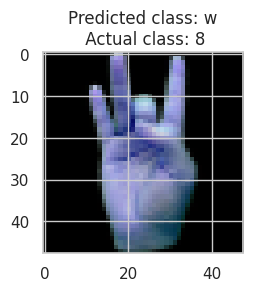

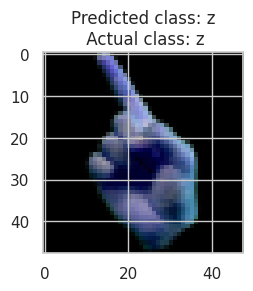

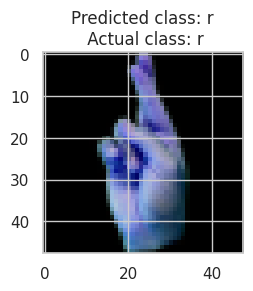

In [107]:
# print images with actiual abnd predicted class labels
for i in range(20):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  # Use np.argmax to get predicted class index
  pred = np.argmax(model.predict(np.array([X_test[i]])))
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  # plt.title("Actual class: {}".format(enc.classes_[act]))
  plt.imshow(X_test[i])

# VGG_16 Model

In [77]:
# import the vgg16 model
from keras.applications.vgg16 import VGG16


In [78]:
vgg=VGG16(weights='imagenet',include_top=False,input_shape=(48,48,3))

In [79]:
vgg.trainable=False

In [80]:
# Set the vgg16 model

model_1=Sequential()
model_1.add(vgg)
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(36, activation='softmax'))

In [81]:
#Compile the model
opt = Adam(learning_rate=0.001)

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_1.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

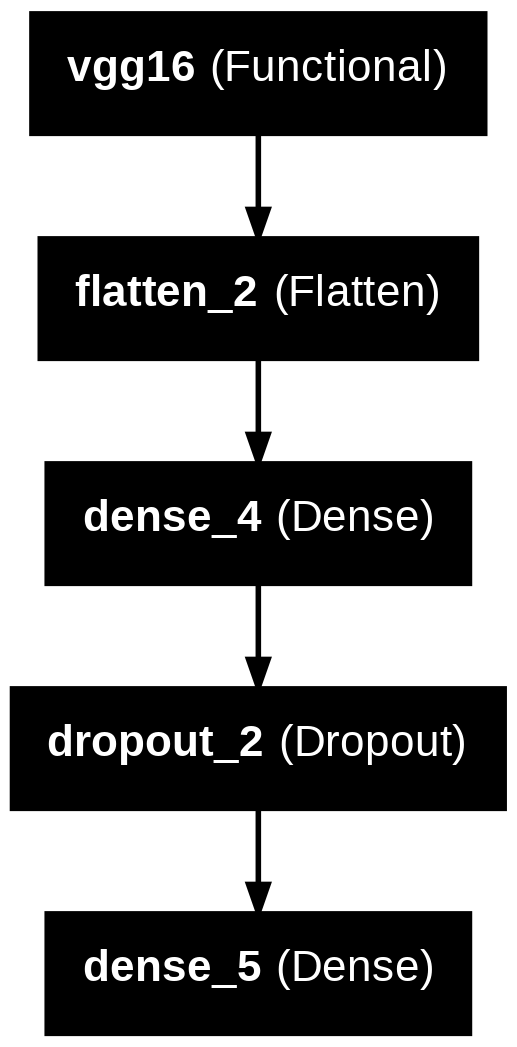

In [82]:
from tensorflow.keras.utils import plot_model

plot_model(model_1, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

In [86]:
#Fit the data or train the model
History_1 = model_1.fit(X_train, y_train, epochs = 5, validation_data = (X_test,y_test),batch_size = 128)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9209 - loss: 0.2393 - val_accuracy: 0.9338 - val_loss: 0.2204
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9462 - loss: 0.1565 - val_accuracy: 0.9391 - val_loss: 0.1895
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9552 - loss: 0.1357 - val_accuracy: 0.9483 - val_loss: 0.1787
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9394 - loss: 0.1671 - val_accuracy: 0.9457 - val_loss: 0.1503
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9565 - loss: 0.1204 - val_accuracy: 0.9391 - val_loss: 0.1693


In [87]:
file_name = '/content/drive/MyDrive/ml/sign_language_vgg-16.h5'

In [89]:
# Save the model
tf.keras.models.save_model(model_1,file_name)

In [90]:
# print the test accuracy
score_2 = model_1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_2[1])

Test accuracy: 0.939072847366333


In [108]:
new = ['VGG-16 ',score_2[1]]
results.loc[2] = new

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


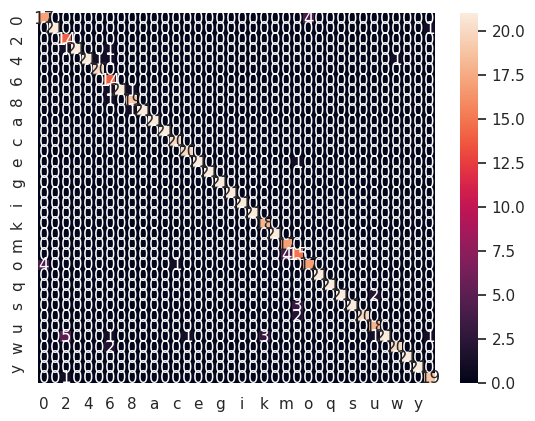

In [109]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names = enc.classes_
# Get predicted labels as discrete values instead of probabilities
y_pred = np.argmax(model_1.predict(X_test), axis=1)
df_heatmap = pd.DataFrame(confusion_matrix(y_pred,np.argmax(y_test,axis=1)),columns=class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

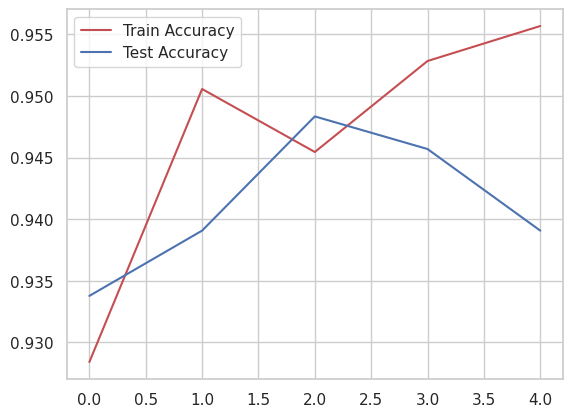

In [110]:
# plot the accuracy plot
plt.plot(History_1.history['accuracy'], 'r')
plt.plot(History_1.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

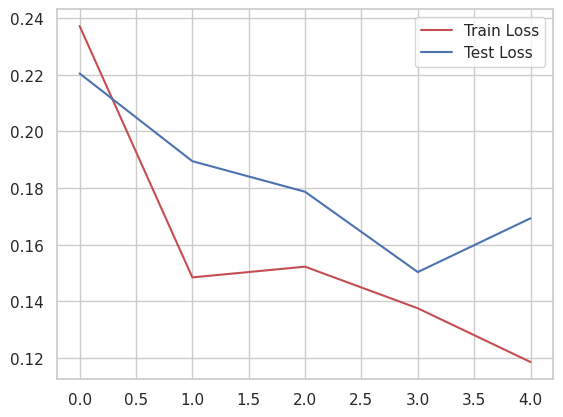

In [111]:
# plot the accuracy plot
plt.plot(History_1.history['loss'], 'r')
plt.plot(History_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


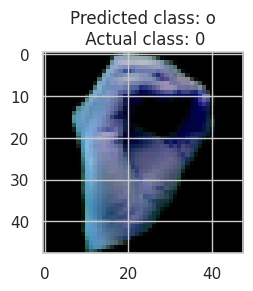

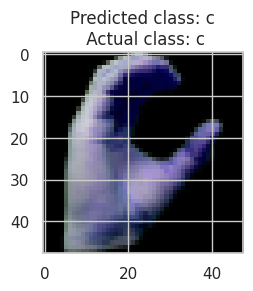

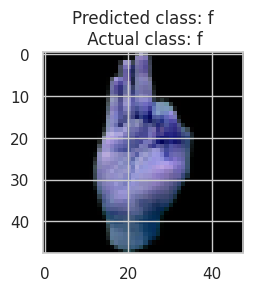

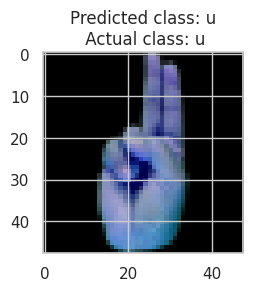

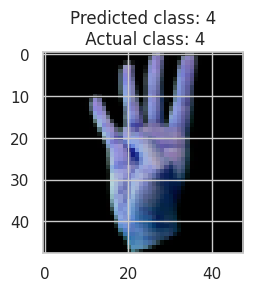

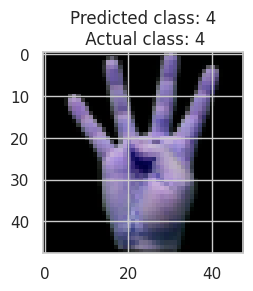

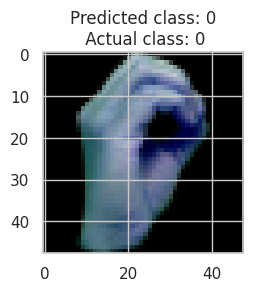

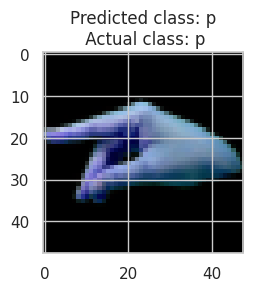

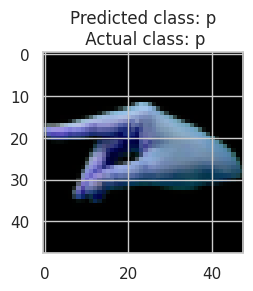

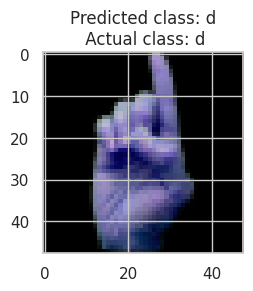

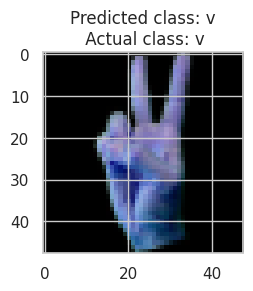

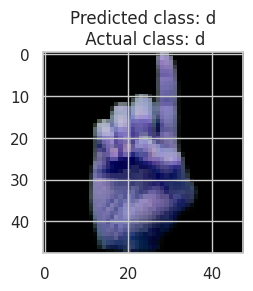

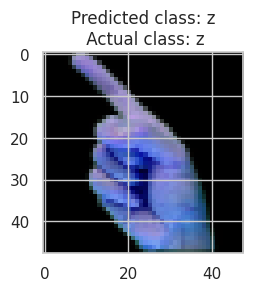

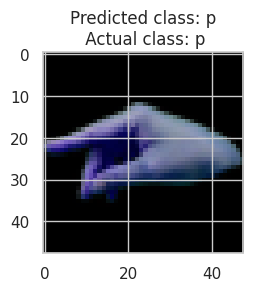

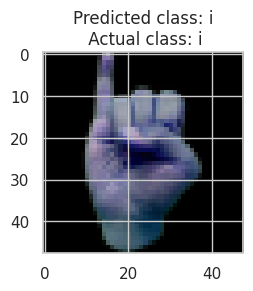

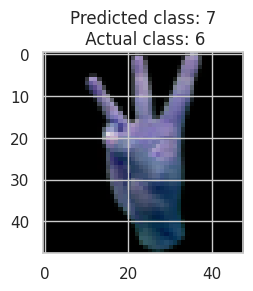

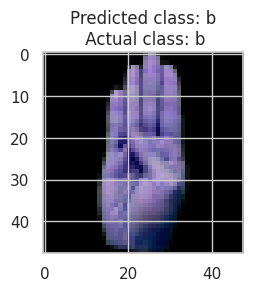

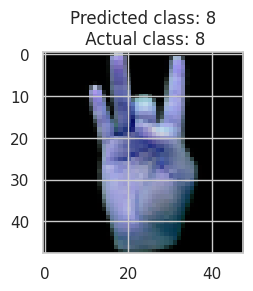

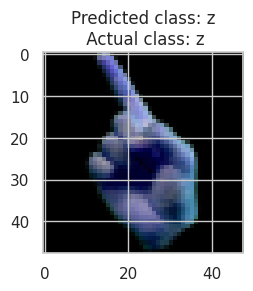

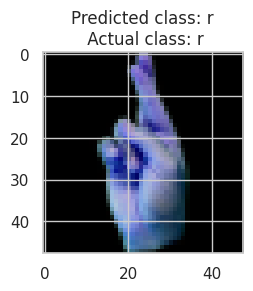

In [112]:
# print images with actiual abnd predicted class labels
for i in range(20):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  # Use np.argmax to get predicted class index
  pred = np.argmax(model_1.predict(np.array([X_test[i]])))
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  # plt.title("Actual class: {}".format(enc.classes_[act]))
  plt.imshow(X_test[i])

## Performance Table

In [113]:
results

,Model,Test Accuracy
1,CNN,0.728477
2,VGG-16,0.939073
